# Installs & Imports

In [1]:
!pip install -q yfinance vectorbt plotly kaleido

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import vectorbt as vbt
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import plotly.io as pio
from IPython.display import display, Image, SVG
import plotly.express as px

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [4]:
# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

# Data Loading

In [5]:
def download_data(symbol: str, start: str, end: str) -> pd.DataFrame:
    """
    Download historical data for a symbol using yfinance

    Parameters:
        symbol (str): The ticker symbol
        start (str): Start date in YYYY-MM-DD format
        end (str): End date in YYYY-MM-DD format

    Returns:
        pd.DataFrame: DataFrame containing historical market data
    """
    df = yf.download(symbol, start=start, end=end)

    open = df['Open'].values.flatten()
    close = df['Close'].values.flatten()
    low = df['Low'].values.flatten()
    high = df['High'].values.flatten()
    volume = df['Volume'].values.flatten()

    df_new = pd.DataFrame({
        'Open': open,
        'Close': close,
        'Low': low,
        'High': high,
        'Volume': volume
    })

    df_new.index = pd.to_datetime(df.index)
    df = df_new.sort_index()

    # Forward fill missing values
    df.ffill(inplace=True)
    return df

In [6]:
# Load the data
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = download_data(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
# Examine the data
print("Preview of the data:")
display(df.head())

print("\nDataFrame info:")
print(df.info())

print("\nSummary statistics:")
display(df.describe())

Preview of the data:


,Open,Close,Low,High,Volume
Date,,,,,
2019-01-02,128.499137,135.163666,128.070766,136.986704,28146200
2019-01-03,134.177433,131.238663,130.621012,136.647991,22717900
2019-01-04,133.500025,137.425034,133.241020,137.474846,29002100
2019-01-07,137.036517,137.524658,135.392803,138.341530,20089300
2019-01-08,139.357657,141.987610,139.008983,142.595289,26263800



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2019-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
 1   Close   1510 non-null   float64
 2   Low     1510 non-null   float64
 3   High    1510 non-null   float64
 4   Volume  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB
None

Summary statistics:


,Open,Close,Low,High,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,280.378663,280.522213,276.709704,284.212550,2.198434e+07
std,122.720767,122.595680,121.301865,123.837788,1.499717e+07
min,89.737201,88.571655,87.754781,90.115752,4.726100e+06
25%,186.383030,186.759094,183.900015,189.361665,1.351600e+07
50%,258.886072,258.925934,254.398213,263.677770,1.840245e+07
75%,332.430114,332.943184,328.275990,336.195744,2.561982e+07
max,630.991005,632.170044,626.704485,637.885465,2.323166e+08


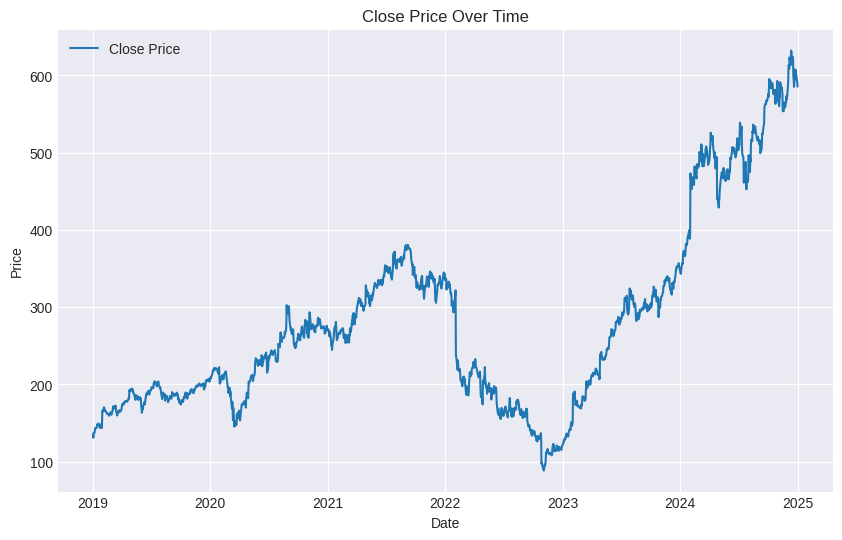

In [8]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Data Preparation

In [9]:
def calculate_pvt(df: pd.DataFrame) -> pd.Series:
    """
    Calculate Price Volume Trend (PVT) using vectorized operations

    Parameters:
        df (pd.DataFrame): DataFrame with 'Close' and 'Volume'

    Returns:
        pd.Series: Price Volume Trend
    """
    pct_change = df['Close'].pct_change().fillna(0)  # Compute daily returns
    pvt = (pct_change * df['Volume']).cumsum()  # Cumulative sum of (return * volume)
    return pvt

In [10]:
def calculate_fisher_transform(df: pd.DataFrame, period: int = 10) -> tuple:
    """
    Calculate Fisher Transform and its signal line

    Parameters:
        df (pd.DataFrame): DataFrame with 'High', 'Low', and 'Close'
        period (int): Lookback period for rolling calculations

    Returns:
        tuple: Fisher Transform and its exponential moving average
    """
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()
    denom = (high_rolling - low_rolling).replace(0, 1e-10)  # Avoid division by zero
    X = 2 * ((df['Close'] - low_rolling) / denom - 0.5)
    X = X.clip(-0.999, 0.999)  # Clip to avoid numerical issues
    fisher = 0.5 * np.log((1 + X) / (1 - X))
    fisher_signal = fisher.ewm(span=9, adjust=False).mean()
    return fisher, fisher_signal

In [11]:
def generate_signals(df: pd.DataFrame, shift: int, fisher_period: int) -> pd.DataFrame:
    """
    Generate trading signals based on PVT and Fisher Transform

    Parameters:
        df (pd.DataFrame): DataFrame with market data
        shift (int): Shift value for comparing PVT values
        fisher_period (int): Period for Fisher Transform calculation

    Returns:
        pd.DataFrame: DataFrame with added columns 'PVT', 'Fisher', 'Fisher_Signal', 'Entry', and 'Exit'
    """
    df = df.copy()
    df['PVT'] = calculate_pvt(df)
    df['Fisher'], df['Fisher_Signal'] = calculate_fisher_transform(df, period=fisher_period)
    df['Entry'] = (df['PVT'] > df['PVT'].shift(shift)) & (df['Fisher'] > df['Fisher_Signal'])
    df['Exit'] = (df['PVT'] < df['PVT'].shift(shift)) & (df['Fisher'] < df['Fisher_Signal'])
    return df

In [12]:
class TradingStrategy:
    """
    Encapsulate trading strategy logic including data preparation and backtesting
    """

    def __init__(self, df: pd.DataFrame):
        """
        Initialize strategy with market data

        Parameters:
            df (pd.DataFrame): Market data DataFrame
        """
        self.df = df.copy()

    def prepare_data(self, shift: int, fisher_period: int) -> pd.DataFrame:
        """
        Prepare market data by calculating indicators and generating signals

        Parameters:
            shift (int): Shift value for PVT comparison
            fisher_period (int): Period for Fisher Transform calculation

        Returns:
            pd.DataFrame: Prepared DataFrame with signals
        """
        return generate_signals(self.df, shift, fisher_period)

    def run_backtest(self, shift: int, fisher_period: int, start_year: int = 2020, end_year: int = 2025,
                     init_cash: float = 100_000, fee: float = 0.001) -> vbt.Portfolio:
        """
        Run backtest for the strategy using specified parameters

        Parameters:
            shift (int): Shift value for PVT signal generation
            fisher_period (int): Period for Fisher Transform calculation
            start_year (int): Starting year of test period
            end_year (int): Ending year of test period
            init_cash (float): Initial portfolio cash
            fee (float): Fee per trade

        Returns:
            vbt.Portfolio: Backtested portfolio
        """
        df_prepared = self.prepare_data(shift, fisher_period)
        df_test = df_prepared[(df_prepared.index.year >= start_year) & (df_prepared.index.year <= end_year)]
        portfolio = vbt.Portfolio.from_signals(
            close=df_test['Close'],
            entries=df_test['Entry'],
            exits=df_test['Exit'],
            init_cash=init_cash,
            fees=fee
        )
        return portfolio

In [13]:
# Example
example_prepared_df = generate_signals(df, shift=26, fisher_period=30)
example_prepared_df.head()

,Open,Close,Low,High,Volume,PVT,Fisher,Fisher_Signal,Entry,Exit
Date,,,,,,,,,,
2019-01-02,128.499137,135.163666,128.070766,136.986704,28146200,0.000000e+00,NaN,NaN,False,False
2019-01-03,134.177433,131.238663,130.621012,136.647991,22717900,-6.597026e+05,NaN,NaN,False,False
2019-01-04,133.500025,137.425034,133.241020,137.474846,29002100,7.074078e+05,NaN,NaN,False,False
2019-01-07,137.036517,137.524658,135.392803,138.341530,20089300,7.219713e+05,NaN,NaN,False,False
2019-01-08,139.357657,141.987610,139.008983,142.595289,26263800,1.574284e+06,NaN,NaN,False,False


# Strategy Optimization

In [14]:
def evaluate_params(params: dict, strategy: TradingStrategy) -> dict:
    """
    Evaluate strategy performance for given parameters

    Parameters:
        params (dict): Contains 'shift' and 'fisher_period'
        strategy (TradingStrategy): Instance of TradingStrategy

    Returns:
        dict: Dictionary with parameters and performance metric
    """
    shift = params['shift']
    fisher_period = params['fisher_period']
    portfolio = strategy.run_backtest(shift, fisher_period)
    performance = portfolio.stats().get('Total Return [%]', np.nan)
    return {'shift': shift, 'fisher_period': fisher_period, 'performance': performance}

In [15]:
shift_values = range(1, 31)           # Shift values from 1 to 30
fisher_period_values = range(5, 31)   # Fisher periods from 5 to 30
param_grid = {'shift': shift_values, 'fisher_period': fisher_period_values}
grid = list(ParameterGrid(param_grid))

In [16]:
# Strategy
strategy = TradingStrategy(df)
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(params, strategy) for params in grid
)
results_df = pd.DataFrame(results)

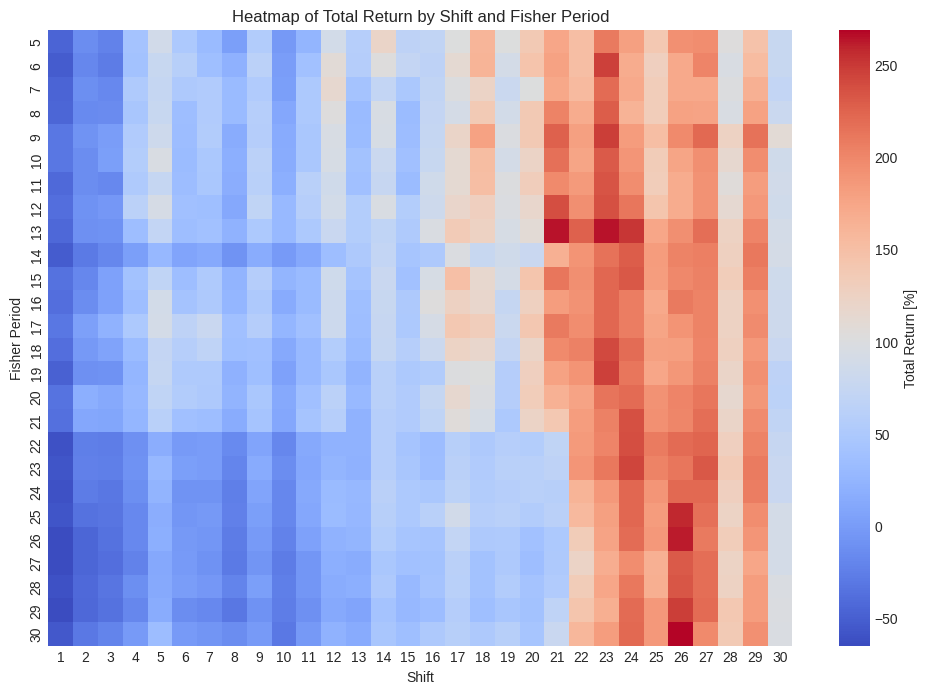

In [17]:
# Heatmap
heatmap_data = results_df.pivot(index='fisher_period', columns='shift', values='performance')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Total Return [%]'})
plt.title("Heatmap of Total Return by Shift and Fisher Period")
plt.xlabel("Shift")
plt.ylabel("Fisher Period")
plt.show()

In [18]:
# Extract best parameters
best_params = results_df.loc[results_df['performance'].idxmax()]
print("Best parameters:")
print(f"Shift: {best_params['shift']}")
print(f"Fisher Period: {best_params['fisher_period']}")
print(f"Total Return [%]: {best_params['performance']}")

Best parameters:
Shift: 26.0
Fisher Period: 30.0
Total Return [%]: 269.0531073017876


# Strategy Evaluation

In [19]:
# Run final backtest using best parameters and display portfolio performance and equity curve
final_shift = int(best_params['shift'])
final_fisher_period = int(best_params['fisher_period'])
final_portfolio = strategy.run_backtest(final_shift, final_fisher_period)

In [20]:
# Performance stats
print("Final Portfolio Performance:")
display(final_portfolio.stats())

Final Portfolio Performance:


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


,0
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,369053.107302
Total Return [%],269.053107
Benchmark Return [%],180.172876
Max Gross Exposure [%],100.0
Total Fees Paid,9516.296237
Max Drawdown [%],48.414642


In [21]:
# Plot
final_portfolio.plot().show()

In [22]:
def display_static_plotly_fig(fig, static_format='png', interactive=True, width=None, height=None):
    """
    Displays an interactive Plotly figure and a static image version,
    or only the static version if interactive is set to False.

    Args:
        fig (plotly.graph_objects.Figure): A Plotly figure object.
        static_format (str, optional): The format for the static image ('png', 'svg', etc.).
                                       Defaults to 'png'.
        interactive (bool, optional): Whether to display the interactive plot.
                                      If False, only the static image is shown.
                                      Defaults to True.
        width (int, optional): The width of the figure in pixels.
        height (int, optional): The height of the figure in pixels.
    """
    # Update the figure layout to control size
    if width is not None or height is not None:
        fig.update_layout(width=width, height=height)

    # Display interactive plot if requested
    if interactive:
        fig.show()
        print("\n")

    # Prepare extra keyword arguments for static image generation
    img_kwargs = {}
    if width is not None:
        img_kwargs['width'] = width
    if height is not None:
        img_kwargs['height'] = height

    # Generate and display static image
    try:
        # Generate static image as bytes, passing width/height if provided
        img_bytes = pio.to_image(fig, format=static_format, **img_kwargs)

        # Display the static image
        if static_format == 'svg':
            display(SVG(img_bytes))
        else:
            display(Image(img_bytes))
    except ValueError as ve:
        print(f"\nInvalid format '{static_format}'. Please choose a supported format (e.g., 'png', 'svg').")
        print(f"Error details: {ve}")
    except Exception as e:
        print(f"\nAn error occurred while generating the static image: {e}")

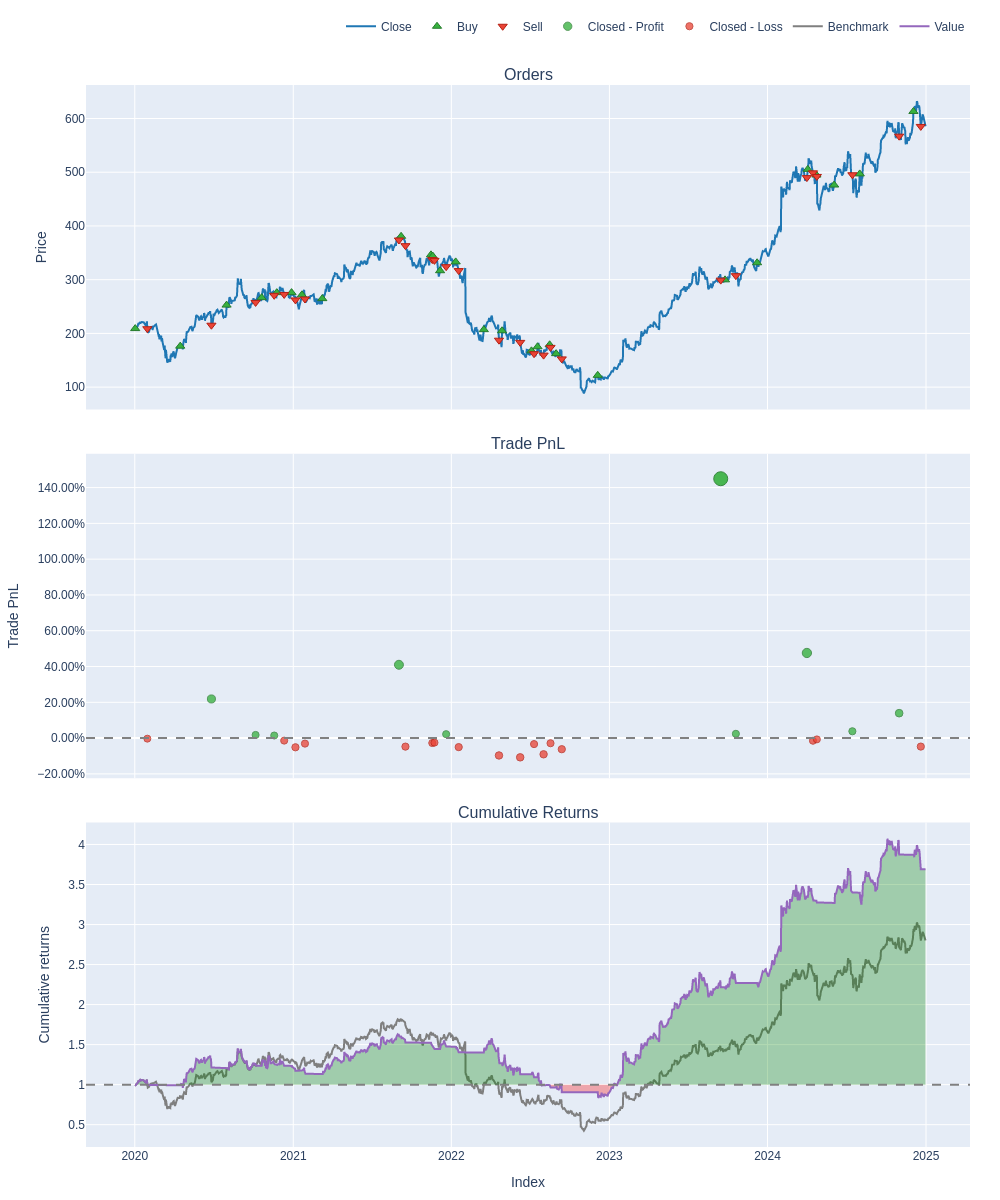

In [23]:
# Plot static version to display on GitHub
display_static_plotly_fig(
    final_portfolio.plot(),
    interactive=False,
    width=1000,
    height=1200
)